In [1]:
from monai import transforms as T
from glob import glob
import os
import numpy as np
import torch
from monai.transforms import LoadImage
from monai.data import  Dataset, DataLoader

image_dir = "/cluster/projects/vc/data/mic/open/OCELOT/ocelot_data/images"
label_dir = "/cluster/projects/vc/data/mic/open/OCELOT/ocelot_data/annotations"

directiories = ['train', 'val', 'test']


In [8]:
def collect_pairs(split):
    print("Current Split: ", split)
    img_tissues = sorted(glob(os.path.join(image_dir, split, "tissue", "*.jpg")))
    img_cells = sorted(glob(os.path.join(image_dir, split, "cell", "*.jpg")))
    
    label_tissues = sorted(glob(os.path.join(label_dir, split, "tissue", "*.png")))
    label_cropped_tissues = sorted(glob(os.path.join(label_dir, split, "cropped_tissue", "*.png")))
    label_cell_masks = sorted(glob(os.path.join(label_dir, split, "cell_mask_images", "*.png")))
    label_cells = sorted(glob(os.path.join(label_dir, split, "cell", "*.csv")))

    print("Number of img_tissues: ", len(img_tissues))
    print("Number of img_cells: ", len(img_cells))
    print("Number of label_tissues: ", len(label_tissues))
    print("Number of label_cropped_tissues: ", len(label_cropped_tissues))
    print("Number of label_cell_masks: ", len(label_cell_masks))
    print("Number of label_cells: ", len(label_cells))

    return [{"img_tissue": i_t, "img_cells": i_c, 
             "label_tissues": l_t, "label_cropped_tissues": l_ct,
             "label_cell_masks": l_cm, "label_cells": l_c}
            for i_t, i_c, l_t, l_ct, l_cm, l_c in zip(img_tissues, img_cells, label_tissues, label_cropped_tissues, label_cell_masks, label_cells)]


In [9]:
train_files = collect_pairs('train')
val_files = collect_pairs('val')
test_files = collect_pairs('test')  

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

Current Split:  train
Number of img_tissues:  400
Number of img_cells:  400
Number of label_tissues:  400
Number of label_cropped_tissues:  400
Number of label_cell_masks:  395
Number of label_cells:  400
Current Split:  val
Number of img_tissues:  137
Number of img_cells:  137
Number of label_tissues:  137
Number of label_cropped_tissues:  137
Number of label_cell_masks:  137
Number of label_cells:  137
Current Split:  test
Number of img_tissues:  126
Number of img_cells:  126
Number of label_tissues:  126
Number of label_cropped_tissues:  126
Number of label_cell_masks:  124
Number of label_cells:  126
Train: 395 | Val: 137 | Test: 124


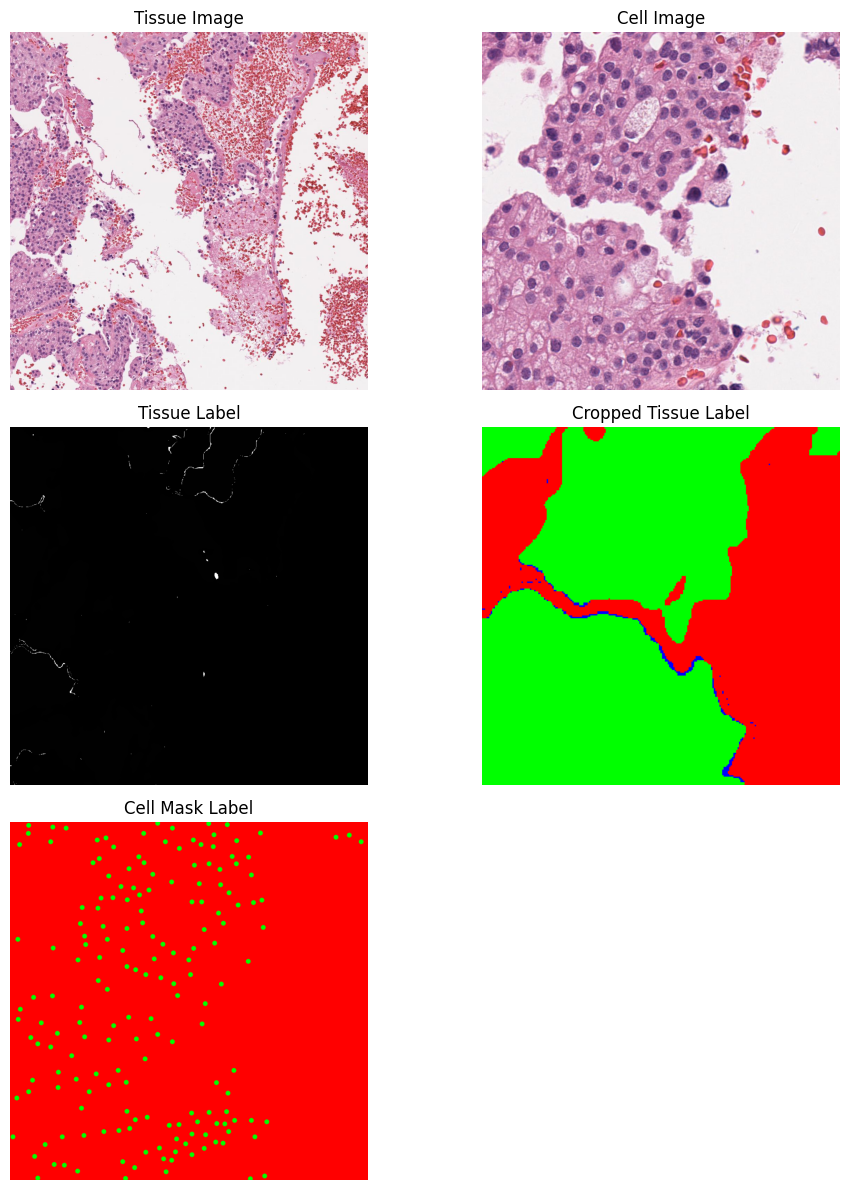

In [36]:
import matplotlib.pyplot as plt
def show_images_grid(img_tissue, label_tissue, img_cell, label_cell_mask, label_cropped_tissue):
    """
    Display images in a 3-row x 2-column grid:
    - Row 1, Col 1: Tissue Image
    - Row 1, Col 2: Cell Image
    - Row 2, Col 1: Tissue Label
    - Row 2, Col 2: Cell Mask Label
    """
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

    images = [
        (img_tissue, "Tissue Image"), 
        (img_cell, "Cell Image"), 
        (label_tissue, "Tissue Label"), 
        (label_cropped_tissue, "Cropped Tissue Label"),
        (label_cell_mask, "Cell Mask Label"),
        
    ]

    for i, (img, title) in enumerate(images):
        row = i // 2 
        col = i % 2   

        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()  

        # Normalize floating point images to [0,1] for visualization
        if img.dtype in [np.float32, np.float64] and img.max() > 1:
            img = img / 255.0

        cmap = "gray" if len(img.shape) == 2 else None  

        axes[row, col].imshow(img, cmap=cmap)
        axes[row, col].set_title(title)
        axes[row, col].axis("off") 
    
    
    for j in range(len(images), 6):  # Max is 6 subplots (3x2 grid)
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

load_image = LoadImage(image_only=True)

sample = train_files[3]  # Pick a sample

img_tissue = load_image(sample["img_tissue"])
label_tissue = load_image(sample["label_tissues"])
img_cell = load_image(sample["img_cells"])
label_cell_mask = load_image(sample["label_cell_masks"])
label_cropped_tissue = load_image(sample["label_cropped_tissues"])
#label_cell = load_image(sample["label_cells"]) isnt of image format

# Display the images in a 3x2 grid
show_images_grid(img_tissue, label_tissue, img_cell, label_cell_mask, label_cropped_tissue)

In [37]:
default_preprocess = T.Compose(
            [
                T.LoadImaged(keys=["img_tissue", "img_cells", "label_tissues", "label_cropped_tissues"]),
                T.EnsureChannelFirstd(keys=["img_tissue", "img_cells", "label_tissues", "label_cropped_tissues"]), 
                T.NormalizeIntensityd(keys=["img_tissue", "img_cells"]),  # Normalize intensity
                T.ConcatItemsd(keys=["img_tissue", "img_cells"], name="image", dim=0),  # Stack images as multi-channel input
                T.ConcatItemsd(keys=["label_tissues", "label_cropped_tissues"], name="label", dim=0),  # Stack labels as multi-channel target
                T.ToTensord(keys=["image", "label"]),  # Convert to PyTorch tensors
            ]
        )

In [49]:
augment = T.Compose([
    T.RandZoomd(keys=["image", "label"], prob=0.7, min_zoom=0.9, max_zoom=1.1),  # Zoom with ±10% resizing
    T.RandCropByLabelClassesd(keys=["image", "label"], label_key="label", spatial_size=[896, 896], num_classes=4, 
                               num_samples=1, ratios=[1, 1, 1, 1]),  # Random crop to 896x896
    T.RandFlipd(keys=["image", "label"], prob=0.7, spatial_axis=[0, 1]),  # Random flip (horizontal or vertical)
    T.RandRotate90d(keys=["image", "label"], prob=0.7),  # Random rotation by 90°, 180°, or 270°
    T.RandAdjustContrastd(keys=["image"], prob=0.7, gamma=(0.8, 1.2)),  # Random brightness and contrast adjustment
])

In [38]:
preprocessed = default_preprocess(train_files[:10])

In [44]:
print(f"Input Shape (Image): {preprocessed[0]['image'].shape}")
print(f"Target Shape (Label): {preprocessed[0]['label'].shape}")

Input Shape (Image): torch.Size([6, 1024, 1024])
Target Shape (Label): torch.Size([4, 1024, 1024])


In [50]:
train_transform = T.Compose([default_preprocess, augment])

In [51]:
final_training_data = train_transform(train_files[:10])

no available indices of class 3 to crop, setting the crop ratio of this class to zero.
no available indices of class 1 to crop, setting the crop ratio of this class to zero.
no available indices of class 2 to crop, setting the crop ratio of this class to zero.
